In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import os
import shutil
import random

{'Cat': 0, 'Cat1': 1, 'Dataset2': 2, 'Dog': 3, 'Dog1': 4, 'train': 5, 'validation': 6}


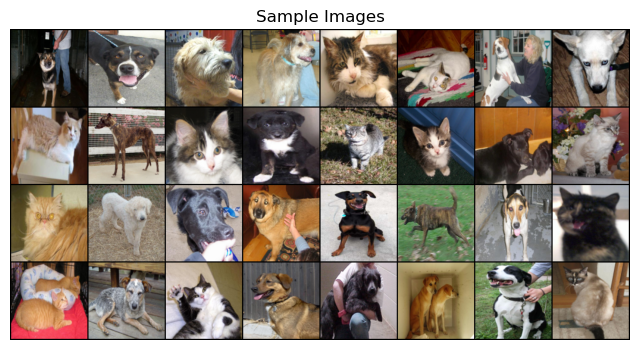

In [2]:
#Import images
# Define transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
])

# Load the dataset
dataset_path = 'PetImages'  # Path to the root folder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check class-to-index mapping
print(dataset.class_to_idx)  # {'cats': 0, 'dogs': 1}

# Get a batch of data
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Display images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(vutils.make_grid(images, normalize=True).permute(1, 2, 0))
plt.show()

In [4]:
# Base directory
#Can change with your file path
base_dir = "PetImages"

# Paths for original Cat and Dog directories
cat_dir = os.path.join(base_dir, "Cat")
dog_dir = os.path.join(base_dir, "Dog")

# Paths for new directories
cat1_dir = os.path.join(base_dir, "Cat1")
cat2_dir = os.path.join(base_dir, "Cat2")
dog1_dir = os.path.join(base_dir, "Dog1")
dog2_dir = os.path.join(base_dir, "Dog2")

# Create new directories if they don't exist
os.makedirs(cat1_dir, exist_ok=True)
os.makedirs(cat2_dir, exist_ok=True)
os.makedirs(dog1_dir, exist_ok=True)
os.makedirs(dog2_dir, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(src_dir, dest_dir1, dest_dir2):
    # Get all files in the source directory
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]

    # Shuffle files for randomness
    random.shuffle(files)

    # Split files into two equal parts
    half = len(files) // 2
    part1_files = files[:half]
    part2_files = files[half:]

    # Copy files to the new directories
    for filename in part1_files:
        shutil.copy(os.path.join(src_dir, filename), os.path.join(dest_dir1, filename))

    for filename in part2_files:
        shutil.copy(os.path.join(src_dir, filename), os.path.join(dest_dir2, filename))

# Split Cat folder
split_and_copy_files(cat_dir, cat1_dir, cat2_dir)

# Split Dog folder
split_and_copy_files(dog_dir, dog1_dir, dog2_dir)

print("Splitting complete!")
print(f"Cat1 contains {len(os.listdir(cat1_dir))} files.")
print(f"Cat2 contains {len(os.listdir(cat2_dir))} files.")
print(f"Dog1 contains {len(os.listdir(dog1_dir))} files.")
print(f"Dog2 contains {len(os.listdir(dog2_dir))} files.")


Splitting complete!
Cat1 contains 9369 files.
Cat2 contains 6251 files.
Dog1 contains 9369 files.
Dog2 contains 6251 files.


In [5]:
#Can change with your file path
base_dir = "PetImages"
cat1_dir = os.path.join(base_dir, "Cat1")
dog1_dir = os.path.join(base_dir, "Dog1")

# Paths for training and validation directories
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

train_cat_dir = os.path.join(train_dir, "Cat")
train_dog_dir = os.path.join(train_dir, "Dog")
val_cat_dir = os.path.join(val_dir, "Cat")
val_dog_dir = os.path.join(val_dir, "Dog")

# Create train and validation directories
os.makedirs(train_cat_dir, exist_ok=True)
os.makedirs(train_dog_dir, exist_ok=True)
os.makedirs(val_cat_dir, exist_ok=True)
os.makedirs(val_dog_dir, exist_ok=True)

# Function to split files into train and validation sets
def split_train_val(src_dir, train_dest_dir, val_dest_dir, split_ratio=0.8):
    # Get all files in the source directory
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]

    # Calculate the split index
    split_index = int(len(files) * split_ratio)

    # Split the files
    train_files = files[:split_index]
    val_files = files[split_index:]

    # Copy files to the corresponding directories
    for filename in train_files:
        shutil.copy(os.path.join(src_dir, filename), os.path.join(train_dest_dir, filename))

    for filename in val_files:
        shutil.copy(os.path.join(src_dir, filename), os.path.join(val_dest_dir, filename))

# Split Cat1 folder
split_train_val(cat1_dir, train_cat_dir, val_cat_dir)

# Split Dog1 folder
split_train_val(dog1_dir, train_dog_dir, val_dog_dir)

print("Train/validation split complete")
print(f"Training Cat images: {len(os.listdir(train_cat_dir))}")
print(f"Validation Cat images: {len(os.listdir(val_cat_dir))}")
print(f"Training Dog images: {len(os.listdir(train_dog_dir))}")
print(f"Validation Dog images: {len(os.listdir(val_dog_dir))}")

Train/validation split complete
Training Cat images: 7495
Validation Cat images: 1876
Training Dog images: 7501
Validation Dog images: 1874


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import ImageFile
from PIL import UnidentifiedImageError

In [14]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
#Can change with your file path
train_dataset = datasets.ImageFolder(root="PetImages/train", transform=transform)
val_dataset = datasets.ImageFolder(root="PetImages/validation", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: RGB images (3 channels)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 18 * 18, 128)  # Adjust input size based on final feature map dimensions
        self.fc2 = nn.Linear(128, 2)  # 2 classes for classification

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
# Helps with some truncated JPEGs (but not all corrupt files)
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 6
LR = 1e-3

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# -----------------------------
# Safe ImageFolder: skip bad files
# -----------------------------
class SafeImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)
        self._filter_bad_images()

    def _filter_bad_images(self):
        good_samples = []
        bad = 0

        for path, label in self.samples:
            try:
                # verify() checks file integrity but doesn't decode fully
                from PIL import Image
                with Image.open(path) as img:
                    img.verify()
                good_samples.append((path, label))
            except Exception:
                bad += 1

        if bad > 0:
            print(f"[SafeImageFolder] Removed {bad} corrupted/unreadable images from: {self.root}")

        self.samples = good_samples
        self.imgs = good_samples  # torchvision uses imgs too

    def __getitem__(self, index):
        # extra safety: if something slips through, skip forward
        while True:
            path, target = self.samples[index]
            try:
                sample = self.loader(path)
                if self.transform is not None:
                    sample = self.transform(sample)
                if self.target_transform is not None:
                    target = self.target_transform(target)
                return sample, target
            except (UnidentifiedImageError, OSError, ValueError):
                index = (index + 1) % len(self.samples)

# -----------------------------
# Datasets + Loaders
# -----------------------------
train_dataset = SafeImageFolder(root="PetImages/train", transform=transform)
val_dataset   = SafeImageFolder(root="PetImages/validation", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -----------------------------
# Model
# -----------------------------
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# -----------------------------
# Train + Validate
# -----------------------------
for epoch in range(EPOCHS):
    print(epoch)

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()

            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_val_loss = val_loss_sum / len(val_loader)
    val_accuracy = 100.0 * correct / total
    print(f"Epoch {epoch}\nVal Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

torch.save(model.state_dict(), "cnn_model.pth")

# -----------------------------
# Evaluate on Dataset2
# -----------------------------
t_model = CNN().to(device)
state = torch.load("cnn_model.pth", map_location=device)
t_model.load_state_dict(state)
t_model.eval()

root = "PetImages/Dataset2"
ds2 = SafeImageFolder(root=root, transform=transform)
loader = DataLoader(ds2, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loss_sum = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = t_model(inputs)
        loss = criterion(outputs, labels)
        test_loss_sum += loss.item()

        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

avg_test_loss = test_loss_sum / len(loader)
test_accuracy = 100.0 * correct / total

print(f"Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")



[SafeImageFolder] Removed 1 corrupted/unreadable images from: PetImages/train
0
Epoch 0
Val Loss: 0.6534, Val Accuracy: 64.43%
1
Epoch 1
Val Loss: 0.5252, Val Accuracy: 74.05%
2
Epoch 2
Val Loss: 0.4976, Val Accuracy: 76.05%
3
Epoch 3
Val Loss: 0.4714, Val Accuracy: 78.51%
4
Epoch 4
Val Loss: 0.5341, Val Accuracy: 76.72%
5
Epoch 5
Val Loss: 0.5107, Val Accuracy: 77.39%
[SafeImageFolder] Removed 2 corrupted/unreadable images from: PetImages/Dataset2
Loss: 0.3951, Accuracy: 83.77%
